In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For curve fitting (instead of statsmodels.tsa or sklearn.linear_model)
from scipy.optimize import curve_fit
df = pd.read_csv('df_wa.csv')

In [3]:
df['Model Year Date'] = pd.to_datetime(df['Model Year'].astype(str) + '-12-31')
print("\n'Model Year Date' column recreated.")


'Model Year Date' column recreated.


In [4]:
# Aggregate the cumulative number of unique EVs per Model Year Date
# Why: To create a single series that represents the total EV population over time.
#      Each 'DOL Vehicle ID' is a unique registration, and we sum them cumulatively by year.
# How:
# 1. df.groupby('Model Year Date'): Groups all the individual car records by their year.
# 2. ['DOL Vehicle ID'].nunique(): For each year, counts how many *unique* vehicles there are.
# 3. .sort_index(): Ensures the years are in the correct chronological order.
# 4. .cumsum():  adds up the unique counts from previous years to get the
#    'cumulative' total up to that year. (e.g., 2010 EVs + 2011 EVs = Cumulative EVs for 2011)
# 5. .name = 'Cumulative EVs': Just gives our new series a readable name.
ev_population_ts_wa = df.groupby('Model Year Date')['DOL Vehicle ID'].nunique().sort_index().cumsum()
ev_population_ts_wa.name = 'Cumulative EVs'


print("\n--- Prepared WA Cumulative EV Population Time Series ---")
print(ev_population_ts_wa.head())
print(ev_population_ts_wa.tail())


--- Prepared WA Cumulative EV Population Time Series ---
Model Year Date
1997-12-31     1
1998-12-31     2
1999-12-31     7
2000-12-31    14
2002-12-31    16
Name: Cumulative EVs, dtype: int64
Model Year Date
2020-12-31     66111
2021-12-31     85174
2022-12-31    112882
2023-12-31    170401
2024-12-31    177473
Name: Cumulative EVs, dtype: int64


In [5]:
# --- 3. Forecast using Exponential Growth Curve Fitting ---


# First, we define the mathematical shape of an exponential curve.
def exp_growth(x, a, b):
    return a * np.exp(b * x)

# Now, we prepare our historical data for the curve fitting tool.
# We'll use data up to 2023 to find the best-fitting curve.
# Why 2023? Because 2024 data might not be complete yet (dataset last updated mid-2025).
# Using complete historical years helps the model learn a consistent trend.
ev_registration_counts = ev_population_ts_wa.copy() # Make a copy to work with
filtered_years = ev_registration_counts[ev_registration_counts.index.year <= 2023]

# 'x_data' will be our time variable for fitting. It needs to be simple numbers.
# How: We calculate years relative to the first year (e.g., 1997 is year 0, 1998 is year 1, etc.).
x_data = (filtered_years.index.year - filtered_years.index.min().year).values

# 'y_data' will be our actual cumulative EV numbers for those years.
y_data = filtered_years.values

# Now, we use 'curve_fit' to find the best 'a' and 'b' for our 'exp_growth' rule.
# How: 'curve_fit' is a function from the 'scipy.optimize' library.
#      It takes our exponential function, the 'x' values (years), and the 'y' values (EV counts).
#      It then calculates the 'a' and 'b' parameters that make our 'exp_growth' curve
#      match our 'y_data' (actual EV counts) as closely as possible.
params, covariance = curve_fit(exp_growth, x_data, y_data)

# 'params' now holds our optimized 'a' and 'b' values.
# params[0] is our 'a' (initial scaling factor)
# params[1] is our 'b' (growth rate constant)
print(f"\nFitted exponential growth parameters: a={params[0]:.4f}, b={params[1]:.4f}")


Fitted exponential growth parameters: a=65.3151, b=0.3012


In [6]:
# Now, we use the fitted function (with our best 'a' and 'b') to forecast for future years.
# Why: This is where we extend our learned pattern into the unknown future.
# How: We provide the future years, convert them to our 'x_data' scale, and plug them into 'exp_growth'.

# 1. Decide which future years we want to forecast for.
#    'forecast_start_year' is the year *after* our last historical data point (2024).
#    'forecast_end_year' is how far into the future we want to predict (e.g., 2035).
forecast_start_year = ev_registration_counts.index.max().year + 1 # This will be 2025
forecast_end_year = 2035 # You can change this to 2030 or 2040 if you prefer.

# 2. Create a list of these future years as simple numbers.
forecast_years_numerical = np.arange(forecast_start_year, forecast_end_year + 1)

# 3. Convert these future years into the same 'x_data' scale (years since our base year)
#    Why: Our 'exp_growth' function was trained on x_data that started from 0 (1997=0, 1998=1, etc.).
#    We need to keep that same scale for forecasting to ensure the 'x' values match the 'b' parameter's meaning.
base_year = filtered_years.index.min().year # This is 1997
forecast_x_data = forecast_years_numerical - base_year

# 4. Use our fitted 'exp_growth' function (with its 'a' and 'b' parameters)
#    and plug in these 'future x_data' values to get the predicted EV counts.
#    The `*params` syntax "unpacks" the 'a' and 'b' values from our 'params' array.
forecasted_values = exp_growth(forecast_x_data, *params)

# 5. Store these forecasted values in a nice Pandas Series with proper year dates.
#    Why: To make it easy to see which forecast belongs to which year, and for plotting.
forecast_series = pd.Series(
    forecasted_values,
    index=pd.to_datetime(forecast_years_numerical.astype(str) + '-12-31')
)

print("\n--- Forecasted EV Market Size (Cumulative) ---")
print(forecast_series)


--- Forecasted EV Market Size (Cumulative) ---
2025-12-31    3.000911e+05
2026-12-31    4.055528e+05
2027-12-31    5.480771e+05
2028-12-31    7.406891e+05
2029-12-31    1.000991e+06
2030-12-31    1.352772e+06
2031-12-31    1.828179e+06
2032-12-31    2.470660e+06
2033-12-31    3.338929e+06
2034-12-31    4.512337e+06
2035-12-31    6.098117e+06
dtype: float64


In [7]:
# Estimate Compound Annual Growth Rate (CAGR) from the Model

# Get the 'b' parameter from your fitted model
# Why: The 'b' parameter in np.exp(b * x) represents the continuous growth rate.
# How: It's the second value in the 'params' array (index 1).
b_parameter = params[1]

# Calculate the Estimated Compound Annual Growth Rate (CAGR)
# Why: To convert the continuous growth rate 'b' into an intuitive annual percentage growth.
# How: The formula for converting a continuous growth rate 'b' to a discrete annual rate is (e^b - 1).
cagr_from_model = np.exp(b_parameter) - 1

print(f"\nEstimated Compound Annual Growth Rate (CAGR) from model: {cagr_from_model:.2%}")


Estimated Compound Annual Growth Rate (CAGR) from model: 35.14%


In [8]:
# Historical Compound Annual Growth Rate (CAGR) (e.g., 2018-2023)

# Define the historical period for which we want to calculate CAGR
# Why: To get a snapshot of growth over a recent, relevant past period.
# How: Select the cumulative EV counts for the start and end years of your chosen period.
start_year_historical_cagr = 2018
end_year_historical_cagr = 2023

# Get the cumulative EV count for the start and end of the period
# Why: These are the 'Beginning Value' and 'Ending Value' for our CAGR formula.
# How: Access the values from the 'ev_population_ts_wa' Series using their year-end dates.
# .iloc[0] is used because filtering by year gives a Series, and we just need the single value.
start_val_cagr = ev_population_ts_wa[ev_population_ts_wa.index.year == start_year_historical_cagr].iloc[0]
end_val_cagr = ev_population_ts_wa[ev_population_ts_wa.index.year == end_year_historical_cagr].iloc[0]

# Calculate the number of years in the period
# Why: This is the 'Number of Years' exponent in our CAGR formula.
num_years_cagr = end_year_historical_cagr - start_year_historical_cagr

# Calculate the Historical CAGR using the formula
# How: (Ending Value / Beginning Value)^(1 / Number of Years) - 1
historical_cagr = ((end_val_cagr / start_val_cagr)**(1 / num_years_cagr)) - 1

print(f"Historical CAGR ({start_year_historical_cagr}-{end_year_historical_cagr}): {historical_cagr:.2%}")


Historical CAGR (2018-2023): 31.43%


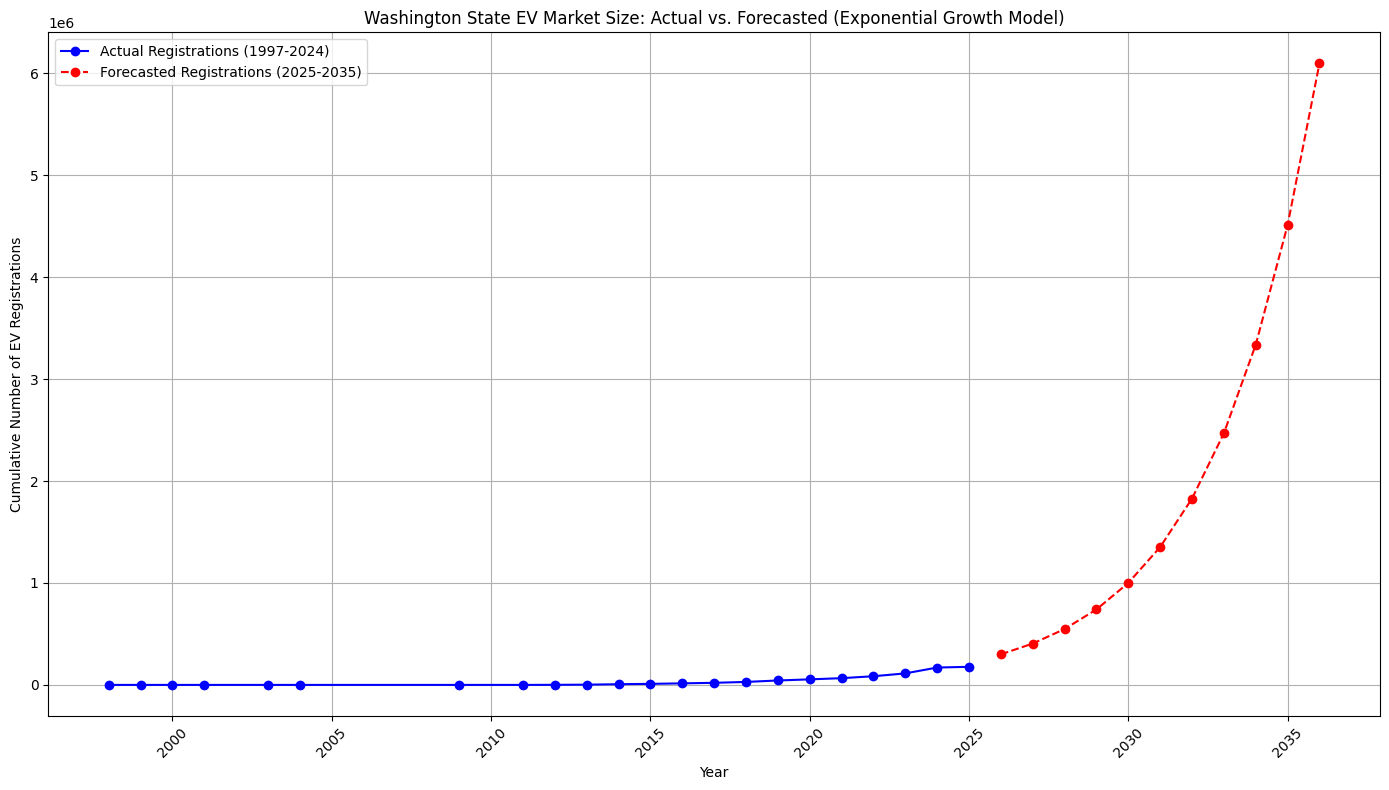

In [9]:
# Plot the Estimated Market Size Data (Actual + Forecast) ---
# Why: Visualizing the forecast is crucial for interpretation and presenting insights.
plt.figure(figsize=(14, 8))

# Plot Actual Registrations (all historical data)
plt.plot(ev_registration_counts.index, ev_registration_counts.values, 'bo-', label='Actual Registrations (1997-2024)')

# Plot Forecasted Registrations
plt.plot(forecast_series.index, forecast_series.values, 'ro--', label=f'Forecasted Registrations ({forecast_start_year}-{forecast_end_year})')

plt.title('Washington State EV Market Size: Actual vs. Forecasted (Exponential Growth Model)')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of EV Registrations')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('wa_ev_market_forecast_exponential_growth.png')
plt.show()

# Analysis of Your Forecasting Results:

**Forecasted EV Market Size (Cumulative):**

The forecast from 2025 to 2035 shows a truly impressive projected growth:

2025: ~300,911 EVs

2030: ~1,352,772 EVs (Over 1.3 million!)

2035: ~6,098,117 EVs (Over 6 million!)

These numbers clearly illustrate that if the historical exponential growth trend continues, Washington State is poised for massive EV adoption in the coming decade, potentially exceeding 6 million EVs by 2035.

---------------------------------------------------------

**Estimated Compound Annual Growth Rate (CAGR) from model: 35.14%**

- Interpretation: This is the average annual growth rate implied by the fitted exponential model. It suggests that, on average, the cumulative EV population is expected to grow by about 35.14% year-over-year.

**Comparison with Historical CAGR (2018-2023): 31.43%**

- The model's projected CAGR (35.14%) is slightly higher than the historical CAGR from 2018-2023 (31.43%). This suggests that the model, by fitting the overall exponential curve, is capturing the accelerating nature of the growth, and projecting a continuation of that momentum.

----------------------------------------------------------

**"Washington State EV Market Size: Actual vs. Forecasted" Plot:**
- The plot dramatically visualizes the projected exponential increase into the future. The steepness of the red dashed line communicates the rapid growth potential.
- A projection to over 6 million EVs by 2035 has massive implications for infrastructure planning (charging stations!), energy grid demands, policy incentives, and automotive sales strategies.



In [ ]:
# Example: Exporting the cumulative forecast data if you want it separate for dashboard
# Combine actuals and forecast into one DataFrame for easy dashboard import
combined_forecast_df = pd.concat([ev_population_ts_wa, forecast_series])
combined_forecast_df = combined_forecast_df.reset_index()
combined_forecast_df.columns = ['Model Year Date', 'Cumulative EVs']
combined_forecast_df.to_csv('combined_ev_forecast.csv', index=False)
print("Combined actuals and forecast saved to combined_ev_forecast.csv")



Combined actuals and forecast saved to combined_ev_forecast.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:


# Combine actuals and forecast into one DataFrame for easy dashboard import
# Why: To have all time series data (historical and projected) in a single table for Power BI.
# How: Use pd.concat to stack the actuals and forecast series.
combined_forecast_df = pd.concat([ev_population_ts_wa, forecast_series])
combined_forecast_df = combined_forecast_df.reset_index()
combined_forecast_df.columns = ['Model Year Date', 'Cumulative EVs']

# NEW: Add the 'Data Type' column in Python
# Why: To easily distinguish 'Actual' historical data from 'Forecast' data in Power BI.
# How: Check if the year is <= 2024 (your last full actual year); if so, it's 'Actual', otherwise 'Forecast'.
combined_forecast_df['Data Type'] = np.where(
    combined_forecast_df['Model Year Date'].dt.year <= 2024,
    "Actual",
    "Forecast"
)

print("\n--- Combined Forecast DataFrame with Data Type Column ---")
print(combined_forecast_df.head())
print(combined_forecast_df.tail())
print(combined_forecast_df['Data Type'].value_counts())


--- Combined Forecast DataFrame with Data Type Column ---
  Model Year Date  Cumulative EVs Data Type
0      1997-12-31             1.0    Actual
1      1998-12-31             2.0    Actual
2      1999-12-31             7.0    Actual
3      2000-12-31            14.0    Actual
4      2002-12-31            16.0    Actual
   Model Year Date  Cumulative EVs Data Type
28      2031-12-31    1.828179e+06  Forecast
29      2032-12-31    2.470660e+06  Forecast
30      2033-12-31    3.338929e+06  Forecast
31      2034-12-31    4.512337e+06  Forecast
32      2035-12-31    6.098117e+06  Forecast
Data Type
Actual      22
Forecast    11
Name: count, dtype: int64


In [17]:
output_file_path = 'combined_ev_forecast_fixed.csv'
combined_forecast_df.to_csv(output_file_path, index=False)
print(f"\nProcessed data saved to: {output_file_path}")


Processed data saved to: combined_ev_forecast_fixed.csv
